In [3]:
import cv2
import os
import glob
import json
import pandas as pd 
from pycocotools.coco import COCO
from PIL import Image
import numpy as np 
import skimage.io as io
from matplotlib import pyplot as plt
from pprint import pprint
from matplotlib.cm import viridis
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import shutil
import random

In [4]:
def load_data(datapath):
    dataloader=DataLoader(Mydataset(datapath),batch_size=16,shuffle=True)
    tensor_list_image=[]
    tensor_list_mask_4d=[]
    tensor_list_mask_3d=[]
    for i,(image,mask_image,mask_output) in enumerate(dataloader):
        tensor_list_mask_4d.append(mask_image)
        tensor_list_image.append(image)
        tensor_list_mask_3d.append(mask_output)
    torch.save(tensor_list_mask_3d, 'groupproject/tensorlist/tensor_list_mask_3d.pt')
    torch.save(tensor_list_mask_4d,  'groupproject/tensorlist/tensor_list_mask_4d.pt')
    torch.save(tensor_list_image,  'groupproject/tensorlist/tensor_list_mask_image.pt')
    

Unet:

In [6]:
class Conv(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Conv, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,3,1,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(),
            nn.Conv2d(out_channel,out_channel,3,1,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU()
        )
    
    def forward(self,x):
        return self.layer(x)
    
class DownSample(nn.Module):
    def __init__(self, channel):
        super(DownSample, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(channel,channel,3,2,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(channel),
            nn.LeakyReLU(),
        )

    def forward(self,x):
        return self.layer(x)

class UpSample(nn.Module):
    def __init__(self, channel):
        super(UpSample, self).__init__()
        self.layer=nn.Conv2d(channel,channel//2,1,1)

    def forward(self,x,feature):
        up=F.interpolate(x,scale_factor=2,mode='nearest')
        out= self.layer(up)
        return torch.cat((out, feature),dim=1)


class Unet(nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        self.c1=Conv(3,64)
        self.d1=DownSample(64)
        self.c2=Conv(64,128)
        self.d2=DownSample(128)
        self.c3=Conv(128,256)
        self.d3=DownSample(256)
        self.c4=Conv(256,512)
        self.d4=DownSample(512)
        self.c5=Conv(512,1024)
        self.u1=UpSample(1024)
        self.c6=Conv(1024,512)
        self.u2 = UpSample(512)
        self.c7 = Conv(512, 256)
        self.u3 = UpSample(256)
        self.c8 = Conv(256, 128)
        self.u4 = UpSample(128)
        self.c9 = Conv(128, 64)
        self.out=nn.Conv2d(64,4,3,1,1)
        
    def forward(self,x):
        R1=self.c1(x)
        R2=self.c2(self.d1(R1))
        R3 = self.c3(self.d2(R2))
        R4 = self.c4(self.d3(R3))
        R5 = self.c5(self.d4(R4))
        O1=self.c6(self.u1(R5,R4))
        O2 = self.c7(self.u2(O1, R3))
        O3 = self.c8(self.u3(O2, R2))
        O4 = self.c9(self.u4(O3, R1))

        return self.out(O4)

musk images:

In [9]:
with open('annotations.json', 'r', encoding='utf8') as file:
    data = json.load(file)
coco = COCO('annotations.json')

loading annotations into memory...
Done (t=2.35s)
creating index...
index created!


In [13]:
def dataprocessing(path):
    files=os.listdir(path)
    for file in files:
        images=os.listdir(f'{path}'+'/'+f'{file}')
        for image in images:
            path_=(path+'/'+file+'./'+image)

def musking(image_id):
    image_path='/musks'
    img = coco.imgs[image_id]
    if not os.path.exists(f'masks/{img['identity']}/{img['file_name'][11:]}'):
        image = np.array(Image.open(img['file_name']))
        plt.imshow(image)
        cat_ids = coco.getCatIds()
        anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(anns_ids)
        if anns!=[]:
            category_colors = {1: viridis(0.1)[:3],
                               2: viridis(0.5)[:3],
                               3: viridis(0.9)[:3]}
            colored_mask = np.zeros((image.shape[0], image.shape[1], 3))
            for ann in anns:
                category_id = ann['category_id']
                binary_mask = coco.annToMask(ann)
                for i in range(3):
                    colored_mask[:,:,i] += binary_mask * category_colors[category_id][i]
            colored_mask = np.clip(colored_mask, 0, 1)
            plt.imshow(colored_mask)
            plt.axis('off')
            if not os.path.exists('masks'):
                os.makedirs('masks')
            if not os.path.exists('masks/'+img['identity']):
                os.makedirs('masks/'+img['identity'])
            plt.savefig(f'masks/{img['identity']}/{img['file_name'][11:]}',bbox_inches='tight')
        plt.clf()
n=0
for i in range(1,8730):
    if n in [1000,2000,3000,4000,5000,6000,7000,8000]:
        print(n)
    musking(i)
    n+=1

1000
2000
3000
4000
5000
6000
7000
8000


<Figure size 640x480 with 0 Axes>

In [15]:
image_dir = 'images' 
mask_dir= 'masks'
def delete_folders(main_dir):
    for root, dirs, files in os.walk(main_dir):
        for file in files:
            file_path = os.path.join(root, file)
            shutil.move(file_path, os.path.join(main_dir, file))
        for dir in list(dirs):
            dir_path = os.path.join(root, dir)
            if not os.listdir(dir_path): 
                os.rmdir(dir_path)
delete_folders(image_dir)
delete_folders(image_dir)
delete_folders(mask_dir)
delete_folders(mask_dir)

Dataset:

In [10]:
transform=transforms.Compose([transforms.ToTensor()])
class_color_dict={'turtle':(72,35,115),'flipers':(104,180,255),'head':(254,255,153)}
def resize_(path,size=(256,256)):
    image=Image.open(path)
    temp=max(image.size)
    mask=Image.new('RGB',(temp,temp),(0,0,0))
    mask.paste(image)
    mask=mask.resize(size)
    return mask
class Mydataset(Dataset):
    def __init__(self,path):
        self.path=path
        self.name=[]
        for root, dirs, files in os.walk(path):
            for name in files:
                self.name.append(os.path.join(root,name))

    def __len__(self):
        return len(self.name)
    
    def __getitem__(self,index):
        file_name=self.name[index]
        mask_path=file_name
        image_path=file_name.replace('masks','images')
        mask_image=resize_(mask_path)
        mask_output=mask_image
        image=resize_(image_path)
        mask_image=np.array(mask_image)
        mask_image = mask_image[:, :, 0:1] 
        for x in range(256):
            for y in range(256):
                if np.array_equal(mask_image[x,y,:],[72]):
                    mask_image[x,y,:]=np.array([0])
                elif np.array_equal(mask_image[x,y,:],[104]):
                    mask_image[x,y,:]=np.array([1])
                elif np.array_equal(mask_image[x,y,:],[254]):
                    mask_image[x,y,:]=np.array([2])
                else:
                    mask_image[x,y,:]=np.array([3])
        image=transform(image)
        mask_image= mask_image.transpose(2, 0, 1)
        mask_image=np.squeeze(mask_image)
        mask_image=torch.from_numpy(mask_image)
        mask_output=transform(mask_output)
        return image,mask_image,mask_output

train:

In [21]:

def class_to_color(ndarray):
    output=torch.randn(3,256,256)
    for x in range(256):
        for y in range(256):
            max_axis = np.argmax(ndarray[:,x,y], axis=0)
            if  max_axis==3:
                output[:,x,y]=torch.tensor([0,0,0])
            elif max_axis==0:
                output[:,x,y]=torch.tensor([72,35,115])
            elif max_axis==1:
                output[:,x,y]=torch.tensor([104,180,255])
            elif max_axis==2:
                output[:,x,y]=torch.tensor([254,255,153])
    return output

image_dir = 'images'  
mask_dir = 'masks'
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'
for dir in [train_dir, val_dir, test_dir]:
    os.makedirs(dir, exist_ok=True)
train_images_dir = os.path.join( 'train','images')
val_images_dir = os.path.join( 'val','images')
test_images_dir = os.path.join('test','images')
train_masks_dir = os.path.join( 'train','masks')
val_masks_dir = os.path.join( 'val','masks')
test_masks_dir = os.path.join('test','masks')
for dir in [train_images_dir, val_images_dir, test_images_dir,train_masks_dir,val_masks_dir,test_masks_dir]:
    os.makedirs(dir, exist_ok=True)
images = os.listdir(image_dir)
masks = os.listdir(mask_dir)
images = [img for img in images if img in masks]
masks=list(masks)
images.sort()
masks.sort()
data_pairs = list(zip(images, masks))
random.shuffle(data_pairs)
train_size = int(0.6 * len(masks))
val_size = int(0.2 * len(masks))
train_pairs = data_pairs[:train_size]
val_pairs = data_pairs[train_size:train_size + val_size]
test_pairs = data_pairs[train_size + val_size:]
def copy_files(pairs, img_dir,mask_dir,img_dir_target,mask_dir_target):
    for img,mask in pairs:
        shutil.copy(os.path.join(img_dir, img), os.path.join(img_dir_target, img))
        shutil.copy(os.path.join(mask_dir, mask), os.path.join(mask_dir_target, mask))
copy_files(train_pairs,image_dir,mask_dir,train_images_dir, train_masks_dir)
copy_files(val_pairs,image_dir,mask_dir,val_images_dir, val_masks_dir)
copy_files(test_pairs,image_dir,mask_dir,test_images_dir, test_masks_dir)

In [37]:


device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight_path='weights/Unet.pth'
datapath='train/masks'

save_path='evaluate'
if not os.path.exists('evaluate'):
    os.makedirs('evaluate')
dataloader=DataLoader(Mydataset(datapath),batch_size=4,shuffle=True)
net=Unet().to(device)
net.train()
if not os.path.exists('weights'):
    os.makedirs('weights')
if os.path.exists(weight_path):
    net.load_state_dict(torch.load(weight_path))
    print('successful load weight！')
else:
    print('not successful load weight')
opt=optim.Adam(net.parameters(),lr=0.0001)
weights=torch.tensor([12.9,61.48,74.07,1.0]).to(device)
loss_fun=nn.CrossEntropyLoss(weight=weights)
epoch=0
while True:
    for i,(image,mask_image,mask_output) in enumerate(dataloader):
        image,mask_image,mask_output=image.to(device),mask_image.to(device),mask_output.to(device)
        mask_image=mask_image.to(torch.long)
        out=net(image)
        train_loss=loss_fun(out,mask_image)
        opt.zero_grad()
        train_loss.backward()
        opt.step()
        # print(out[0,:,128,128])
        # print(mask_image[0,128,128])
        if i%5==0:
            print(f'epoch:{epoch}-{i},train_loss:{train_loss.item()}')
        if i%50==0:
            torch.save(net.state_dict(),weight_path)
        if i%100==0:
            _image=image[0]
            _mask=mask_output[0]
            _out=out[0]
            output=_out.detach().cpu().numpy()
            output=class_to_color(output)
            output=output.to(device)
            output=output/255
            img=torch.stack([_image,_mask,output],dim=0)
            save_image(img,os.path.join(save_path,str(i))+'.png')
    epoch+=1

C:\Users\lsz\AppData\Local\Temp\ipykernel_19896\2045290911.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(weight_path))


successful load weight！
epoch:0-0,train_loss:0.27679726481437683
epoch:0-5,train_loss:0.21873627603054047
epoch:0-10,train_loss:0.693175733089447


KeyboardInterrupt: 

C:\Users\lsz\AppData\Local\Temp\ipykernel_18656\1813792415.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(weight_path))


successful load weight！
epoch=0,average iou=0.48968626681760474,turtle_iou=0.4367194004995837,flipers_iou=0.32256693582660434,head_iou=0.300816167897396
average dice=0.6262121200561523,turtle_dice=0.6079397201538086,flipers_dice=0.48778921365737915,head_dice=0.46250373125076294
epoch=100,average iou=0.518998295654744,turtle_iou=0.5037229430877957,flipers_iou=0.1731898213325603,head_iou=0.46621518436456744
average dice=0.6207482857287501,turtle_dice=0.6342367328958494,flipers_dice=0.26758566261214917,head_dice=0.6166829439525557
epoch=200,average iou=0.5131672417608825,turtle_iou=0.4856681514241442,flipers_iou=0.17911933152150214,head_iou=0.46714467734976745
average dice=0.6185084777379788,turtle_dice=0.6160192668786973,flipers_dice=0.2857186855726213,head_dice=0.6150504814006796
epoch=300,average iou=0.5114085699641158,turtle_iou=0.4743089486981389,flipers_iou=0.17115101520369272,head_iou=0.47728714044583975
average dice=0.6173124321487115,turtle_dice=0.6057413825470935,flipers_dice=0.

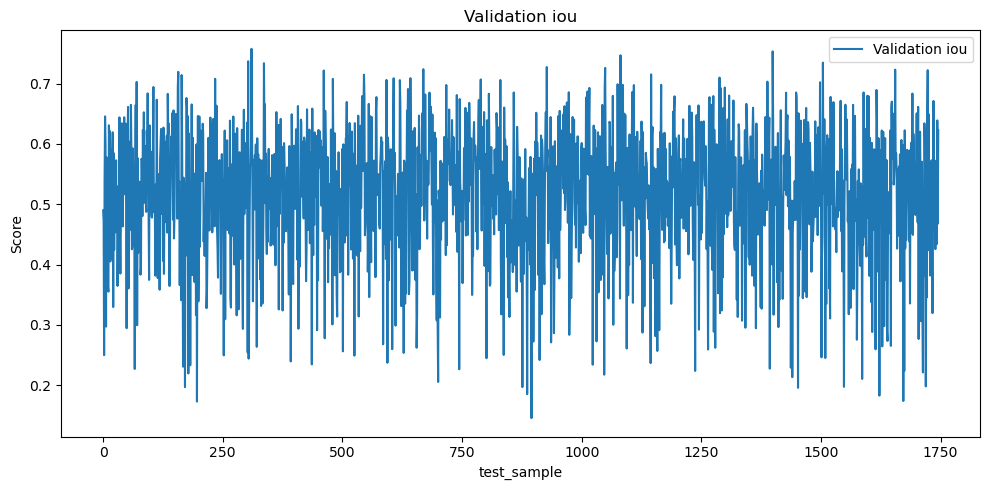

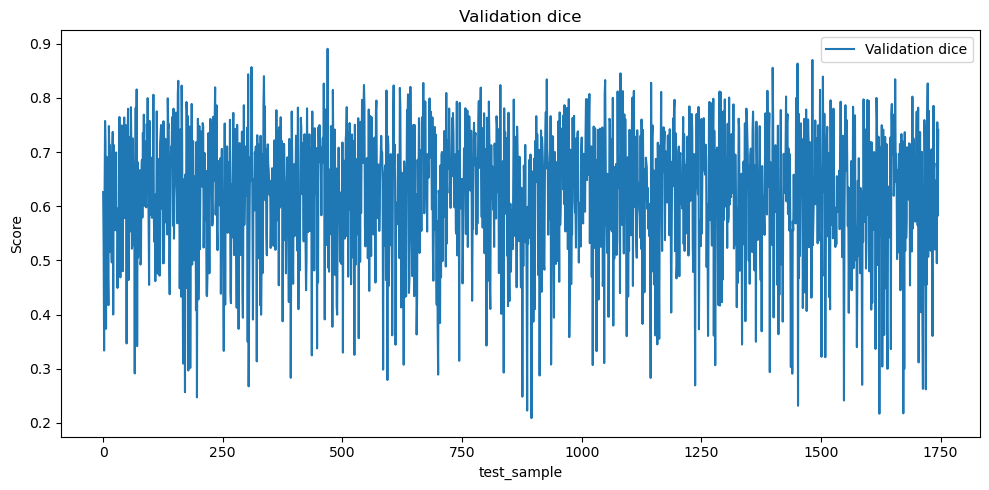

In [30]:
def plot_metrics(val_history,cls):
    plt.figure(figsize=(10, 5))
    
    # draw line chart
    plt.plot(val_history, label='Validation '+cls)
    plt.xlabel('test_sample')
    plt.ylabel('Score')
    plt.title('Validation '+cls)
    plt.legend()
    plt.tight_layout()
    plt.show()
def calculate_iou(predictions, labels, num_classes):
    predicted_classes=predictions.squeeze(0)
    labels=labels.squeeze(0)
    ious = []
    for class_id in range(num_classes):
        intersection = ((predicted_classes == class_id) & (labels == class_id)).sum().item()
        union = ((predicted_classes == class_id) | (labels == class_id)).sum().item()
        if union == 0:
            iou = 0 
        else:
            iou = intersection / union
        ious.append(iou)
    return ious
def calculate_dice(predictions,labels,num_classes):
    predicted_classes=predictions.squeeze(0)
    labels=labels.squeeze(0)
    dice_list = []
    smooth=1e-6
    for class_id in range(num_classes):
        intersection = ((predicted_classes == class_id) & (labels == class_id)).sum().float()
        dice = (2.0 * intersection + smooth) / (predictions.eq(class_id).sum() + labels.eq(class_id).sum() + smooth)
        dice_list.append(dice.item())
    return dice_list
testpath='test/masks'
weight_path='weights/Unet.pth'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net=Unet().to(device)
testloader=DataLoader(Mydataset(testpath),batch_size=1,shuffle=True)
if not os.path.exists('weights'):
    os.makedirs('weights')
if os.path.exists(weight_path):
    net.load_state_dict(torch.load(weight_path))
    print('successful load weight！')
else:
    print('not successful load weight')
net.eval()
iou_history=[]
turtle_iou_history=[]
flipers_iou_history=[]
head_iou_history=[]
dice_history=[]
turtle_dice_history=[]
flipers_dice_history=[]
head_dice_history=[]
with torch.no_grad():
    for i,(image,mask_image,mask_output) in enumerate(testloader):
        image=image.to(device)
        mask_image=mask_image.to(device)
        out=net(image)
        prediction=torch.argmax(out,dim=1)
        ious=calculate_iou(prediction,mask_image,4)
        dice=calculate_dice(prediction,mask_image,4)
        dice_history.append(np.mean(dice))
        turtle_dice_history.append(dice[0])
        flipers_dice_history.append(dice[1])
        head_dice_history.append(dice[2])
        iou_history.append(np.mean(ious))
        turtle_iou_history.append(ious[0])
        flipers_iou_history.append(ious[1])
        head_iou_history.append(ious[2])
        if i%100==0:
            print(f'epoch={i},average iou={np.mean(iou_history)},turtle_iou={np.mean(turtle_iou_history)},flipers_iou={np.mean(flipers_iou_history)},head_iou={np.mean(head_iou_history)}')
            print(f'average dice={np.mean(dice_history)},turtle_dice={np.mean(turtle_dice_history)},flipers_dice={np.mean(flipers_dice_history)},head_dice={np.mean(head_dice_history)}')
    plot_metrics(iou_history,'iou')
    plot_metrics(dice_history,'dice')